In [1]:
import os
from pathlib import Path
import IPython.display as ipd
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import plotly.graph_objs as go
import plotly.offline as py
from IPython import display
import time
from datetime import datetime, timedelta
import tensorflow as tf
import seaborn as sns
from subprocess import check_output
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from PIL import Image
import subprocess
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

# NOTES
NOTES = "MFCC_28x28_Combined_3"

# VARS
target_label = "label"
id_label = "fname"
OUTSTR = "A{:.4f}_Type{}_UDR{}_THRESH{:5.3f}_DROP{}_LR{}_S{}_B{}{}.csv"
IMG_EXT = ".png"
VERBOSE = True
DISPLAY = True
TEST = False
MFCC = True
TPU = False
TARGET_WIDTH = 128
TARGET_HEIGHT = 128
DECAY_RATE = 0.9
CHANNELS = 3
DROPOUT = 0.4
TYPE = "CNN"
DEFAULT_BS = 128 # default batch size
UNK_DROP_RATE = 1.0 # drop 100% of unknown categories

if TEST:
    LEARNING_STEPS = 100
    SPP = 4
    LEARNING_RATE = .05
    BATCH_SIZE = 64
    VERBOSITY = 1000
    TEST_SIZE = 1100
    SHUFFLE_SIZE = 1
else:
    LEARNING_STEPS = 20000
    SPP = 800
    LEARNING_RATE = .0375
    BATCH_SIZE = 64
    VERBOSITY = 1000
    SHUFFLE_SIZE = 2500

def curr_time():
    return datetime.now() - timedelta(hours=7) # offset from UTC to PST

IMAGES = "images/"
if MFCC:
    IMAGES="mfcc_noisy/"
KAGGLE = "/home/wesleytocs/.kaggle/competitions/tensorflow-speech-recognition-challenge/"
ROOT = "/home/wesleytocs/Speech/"
CLEAN_DIR = ROOT + "mfcc/" + "train"
# PATHS
paths = {
    "Kaggle":KAGGLE,
    "Training":KAGGLE+"train/audio",
    "Images":ROOT+IMAGES,
    "TrainImg":ROOT+IMAGES+"train",
    "TestImg":ROOT+IMAGES+"test",
    "Testing":KAGGLE+"test/audio",
    "Model":ROOT+"model_dir_CNN_28_combined_short_3/",
    "Logs":ROOT+"logs/CNN_28_{}_combined_short_3/".format(datetime.strftime(curr_time(), "%b%d%Y_%H%M%S"))
}
paths["Log"] = paths["Logs"] + "log.txt"
if not os.path.isdir(paths["Logs"]):
    os.mkdir(paths["Logs"])
if not os.path.isdir(paths["Images"]):
    os.mkdir(paths["Images"])
if not os.path.isdir(paths["TrainImg"]):
    os.mkdir(paths["TrainImg"])
if not os.path.isdir(paths["TestImg"]):
    os.mkdir(paths["TestImg"])

In [2]:
def make_header(s):
    return ("#" * 42) + ("\n{:^42}\n".format(s)) + ("#" * 42)
    
def print_and_log(s):
    with open(paths["Log"], 'a') as log:
        log.write(str(s))
        log.write("\n")
    print(s)
        
def print_and_log_header(s):
    h = make_header(str(s))
    with open(paths["Log"], 'a') as log:
        log.write(h)
        log.write("\n")
    print(h)

In [3]:
def sec_to_str(secs):
    ms = secs - int(secs)
    days = int(secs // (24 * 3600))
    hours = int((secs % ((24 * 3600))) // 3600)
    minutes = int((secs % 3600) // 60)
    seconds = int(secs % 60)
    return "{:02}:{:02}:{:02}:{:02}.{}".format(days, hours, minutes, seconds, "{:.3}".format(ms)[2:])

def timer(f, *args):
    print_and_log("Start: {}".format(curr_time()))
    start = time.time()
    result = f(*args)
    end = time.time()
    print_and_log("End: {}".format(curr_time()))
    print_and_log("Finished in {}".format(sec_to_str(end - start)))
    return result
    
def get_noise():
    files = os.listdir(paths["Training"] + "/silence")
    return paths["Training"] + "/silence/" + random.choice(files)

def preprocess(samples, sample_rate):
    padded = np.zeros(sample_rate)
    samples = samples[:sample_rate]
    padded[:samples.shape[0]] = samples
    return padded

In [4]:
def make_images_from_wav(data_path, image_path, overwrite=False, useLabels=True, noisy=True):
    plt.ioff()
    lbls = all_labels
    if not useLabels:
        lbls = {"":""}
    LABELS = []
    PATHS = []
    items = 0
    found = 0
    created = 0
    for label in lbls:
        label_path = os.path.join(image_path, label)
        print_and_log("\tProcessing: {}".format(label_path))
        if not os.path.isdir(label_path):
            os.mkdir(label_path)
        for file in [item for item in os.listdir(os.path.join(data_path, label)) if item.endswith(".wav")]:
            items += 1
            wavpath = os.path.join(data_path, label, file)
            imgpath = os.path.join(label_path, file[:-4] + ".png")
            if overwrite or not os.path.isfile(imgpath):
                created += 1
                if MFCC:
                    noisepath = get_noise()
                    sample_rate, samples = wavfile.read(wavpath)
                    samples = preprocess(samples, sample_rate)
                    if noisy and (label != "silence"):
                        _, noise = wavfile.read(noisepath)
                        noise = preprocess(noise, _)
                        np.add(samples, noise, out=samples)
                    freqs, times, spectrogram = signal.spectrogram(samples, sample_rate)
                    S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=64, S=spectrogram)
                    log_S = librosa.power_to_db(S, ref=np.max)
                    fig = plt.figure(figsize=(1.28, 1.28), dpi=100, frameon=False)
                    ax = plt.Axes(fig, [0., 0., 1., 1.])
                    ax.set_axis_off()
                    fig.add_axes(ax)
                    plt.axis('off')
                    librosa.display.specshow(log_S)
                    plt.savefig(imgpath)
                    plt.close()
                else:
                    command = ["sox", wavpath, "-n", "spectrogram", "-x", str(TARGET_WIDTH), "-y", str(TARGET_HEIGHT), "-r", "-o", imgpath]
                    subprocess.run(command) # multithread? CPU underutilized here
                if VERBOSE and items % VERBOSITY == 0:
                    print_and_log("\t            Created {}th .png file".format(items))
            else:
                found += 1
                if VERBOSE and items % VERBOSITY == 0:
                    print_and_log("\t            Found {}th .png file".format(items))
            if useLabels:
                LABELS.append(labels.get(label, labels['unknown']))
            PATHS.append(imgpath)
    print_and_log("\tFound:\t\t{}\n\tCreated:\t{}".format(found, created))
    if useLabels:
        df = pd.DataFrame({target_label:LABELS, "Path":PATHS})
    else:
        df = pd.DataFrame({"Path":PATHS})
    plt.ion()
    return df

In [5]:
count = 0
def _parse_function(filename, label):
    global count
    count += 1
    if count % VERBOSITY == 0:
        print_and_log("\tProcessed {}th image".format(count))
    expected_shape = tf.constant([1, TARGET_HEIGHT, TARGET_WIDTH, CHANNELS])
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_image(image_string, channels=CHANNELS)
    image_decoded = tf.image.convert_image_dtype(image_decoded, tf.float32)
    image_decoded = tf.reshape(image_decoded, expected_shape)
    image_decoded = tf.image.rgb_to_grayscale(image_decoded)
    image_decoded = tf.image.resize_bicubic(image_decoded, [28, 28])
    return image_decoded, label

In [6]:
def model_fn(features, labels, mode):
    input_layer = tf.reshape(features, [-1, 28, 28, 1])
    pool = input_layer

    for num_filters in [32, 64]:
        conv = tf.layers.conv2d(
            inputs=pool,
            filters=num_filters,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
        pool = tf.layers.max_pooling2d(inputs=conv, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool = tf.layers.flatten(pool)
    dense = tf.layers.dense(inputs=pool, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=DROPOUT, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=num_labels)
    
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if not TPU:
        tf.summary.histogram("predictions", predictions["probabilities"])
        tf.summary.histogram("classes", predictions["classes"])

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    learning_rate = tf.train.exponential_decay(LEARNING_RATE, tf.train.get_global_step(), SPP, DECAY_RATE, staircase=True)
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    predictions["loss"] = loss
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
        if TPU:
            optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [7]:
def create_training_input_fn(dataset, batch_size, num_epochs=None):
    def _input_fn(num_epochs=None, shuffle=True):
        ds = dataset.batch(batch_size).repeat(num_epochs)
        if shuffle:
            ds = ds.shuffle(SHUFFLE_SIZE)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def create_predict_input_fn(dataset, batch_size):
    def _input_fn():
        ds = dataset.batch(batch_size)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def train_helper(steps_per_period):
    classifier.train(
        input_fn=train_input_fn,
        steps=steps_per_period)
    training_stats = classifier.evaluate(input_fn=training_eval_input_fn)
    validation_stats = classifier.evaluate(input_fn=validation_eval_input_fn)
    t_ll = training_stats["loss"]
    t_acc = 100 * training_stats["accuracy"]
    v_ll = validation_stats["loss"]
    v_acc = 100 * validation_stats["accuracy"]
    return classifier, t_ll, v_ll, t_acc, v_acc

def train():
    periods = LEARNING_STEPS // SPP
    steps_per_period = LEARNING_STEPS // periods
    t_accs, v_accs = [], []
    t_lls, v_lls = [], []
    print_and_log("Training model...\nMetrics:")
    print_and_log("\tPERIOD\tRATE\tTYPE\tTRAIN.\tVALID.\tTIME")
    for period in range(periods):
        lr = LEARNING_RATE * (DECAY_RATE ** ((period * SPP) / SPP))
        classifier, t_ll, v_ll, t_acc, v_acc = train_helper(steps_per_period)
        print_and_log("\t{}\t{:.5f}\tLgLs\t{:.2f}\t{:.2f}\t{}".format(period, lr, t_ll, v_ll, curr_time()))
        print_and_log("\t\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(t_acc, v_acc))
        t_lls.append(t_ll)
        v_lls.append(v_ll)
        t_accs.append(t_acc)
        v_accs.append(v_acc)
    v_accuracy = v_accs[-1]
    return classifier, v_accuracy, t_lls, v_lls, t_accs, v_accs

In [8]:
with open(paths["Log"], 'w') as log:
    log.write(make_header("Starting Script\n"))
    
if VERBOSE:
    print(check_output(["ls", paths["Kaggle"]]).decode("utf8"))
    print(os.listdir(paths["Training"]))

link_to_gcp_credits_form.txt
sample_submission.csv
test
train

['tree', 'five', 'dog', 'happy', 'go', 'right', '_background_noise_', 'marvin', 'no', 'eight', 'one', 'bed', 'bird', 'nine', 'wow', 'two', 'on', 'stop', 'house', 'silence.old', 'left', 'silence', 'seven', 'three', 'sheila', 'zero', 'cat', 'four', 'off', 'yes', 'down', 'up', 'six']


In [9]:
# Create variables for the paths
train_audio_path = paths["Training"]
test_audio_path = paths["Testing"]
train_image_path = paths["TrainImg"]
test_image_path = paths["TestImg"]

# Store the labels to train
all_labels = ['tree', 'five', 'dog', 'happy', 'go', 'right',
          'marvin', 'no', 'eight', 'one', 'bed', 'bird',
          'nine', 'wow', 'two', 'on', 'stop', 'house', 'left',
          'silence', 'seven', 'three', 'sheila', 'zero', 'cat',
          'four', 'off', 'yes', 'down', 'up', 'six']
labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence", "unknown"]
num_labels = len(labels) - 1
labels = {x[1]:x[0] for x in enumerate(labels)}
reverse_lookup = {labels[k]:k for k in labels}

In [10]:
# Make the training data
print_and_log_header("MAKING NOISY TRAINING DATA")
train_data = timer(make_images_from_wav, train_audio_path, train_image_path)
print_and_log_header("MAKING CLEAN TRAINING DATA")
clean_data = timer(make_images_from_wav, train_audio_path, CLEAN_DIR, False, True, False)
clean_data.drop(clean_data[clean_data[target_label] == labels["silence"]].sample(frac=1.0).index, inplace=True)
train_data = train_data.append(clean_data)
train_data = train_data.sample(frac=1).reset_index(drop=True)
if VERBOSE:
    print_and_log_header("TRAIN DATA")
    print_and_log(train_data.describe())
    print_and_log(train_data.head(10))

##########################################
        MAKING NOISY TRAINING DATA        
##########################################
Start: 2018-08-01 02:28:35.259824
	Processing: /home/wesleytocs/Speech/mfcc_noisy/train/tree
	            Found 1000th .png file
	Processing: /home/wesleytocs/Speech/mfcc_noisy/train/five
	            Found 2000th .png file
	            Found 3000th .png file
	            Found 4000th .png file
	Processing: /home/wesleytocs/Speech/mfcc_noisy/train/dog
	            Found 5000th .png file
	Processing: /home/wesleytocs/Speech/mfcc_noisy/train/happy
	            Found 6000th .png file
	            Found 7000th .png file
	Processing: /home/wesleytocs/Speech/mfcc_noisy/train/go
	            Found 8000th .png file
	            Found 9000th .png file
	Processing: /home/wesleytocs/Speech/mfcc_noisy/train/right
	            Found 10000th .png file
	            Found 11000th .png file
	            Found 12000th .png file
	Processing: /home/wesleytocs/Speech/mfcc_noisy/t

	            Found 63000th .png file
	Processing: /home/wesleytocs/Speech/mfcc/train/up
	            Found 64000th .png file
	            Found 65000th .png file
	            Found 66000th .png file
	Processing: /home/wesleytocs/Speech/mfcc/train/six
	            Found 67000th .png file
	            Found 68000th .png file
	Found:		68713
	Created:	0
End: 2018-08-01 02:28:38.974956
Finished in 00:00:00:01.821
##########################################
                TRAIN DATA                
##########################################
               label
count  133434.000000
mean        8.662365
std         3.536030
min         0.000000
25%         7.000000
50%        11.000000
75%        11.000000
max        11.000000
                                                Path  label
0  /home/wesleytocs/Speech/mfcc_noisy/train/down/...      3
1  /home/wesleytocs/Speech/mfcc_noisy/train/five/...     11
2  /home/wesleytocs/Speech/mfcc_noisy/train/up/2b...      2
3  /home/wesleytocs/Speech/mfc

In [11]:
print_and_log_header("MAKING TEST DATA")
test_data = timer(make_images_from_wav, test_audio_path, test_image_path, False, False)
test_data = test_data.reindex(np.random.permutation(test_data.index))
if VERBOSE:
    print_and_log_header("TEST DATA")
    print_and_log(test_data.describe())
    print_and_log(test_data.head(10))

##########################################
             MAKING TEST DATA             
##########################################
Start: 2018-08-01 02:28:39.128247
	Processing: /home/wesleytocs/Speech/mfcc_noisy/test/
	            Found 1000th .png file
	            Found 2000th .png file
	            Found 3000th .png file
	            Found 4000th .png file
	            Found 5000th .png file
	            Found 6000th .png file
	            Found 7000th .png file
	            Found 8000th .png file
	            Found 9000th .png file
	            Found 10000th .png file
	            Found 11000th .png file
	            Found 12000th .png file
	            Found 13000th .png file
	            Found 14000th .png file
	            Found 15000th .png file
	            Found 16000th .png file
	            Found 17000th .png file
	            Found 18000th .png file
	            Found 19000th .png file
	            Found 20000th .png file
	            Found 21000th .png file
	            Fo

In [12]:
ids = pd.Series([os.path.basename(x)[:-4]+".wav" for x in test_data["Path"]]) # store the wav filenames for output
if VERBOSE:
    print_and_log_header("IDS")
    print_and_log(ids.describe())
    print_and_log(ids.head(10))

##########################################
                   IDS                    
##########################################
count                 158538
unique                158538
top       clip_43c1a30f2.wav
freq                       1
dtype: object
0    clip_dc31ab241.wav
1    clip_190c188d3.wav
2    clip_7d21a7eaf.wav
3    clip_a7606f921.wav
4    clip_1b541601f.wav
5    clip_b623c9eb3.wav
6    clip_3202cda66.wav
7    clip_ab543fc6a.wav
8    clip_980d9783e.wav
9    clip_06e93905a.wav
dtype: object


In [13]:
# 80/20 training/validation split
t_size = int(0.8 * train_data.shape[0])
validation_data = train_data[t_size:]
train_data = train_data[:t_size]
test_labels = pd.Series([labels["yes"] for _ in range(test_data.shape[0])], dtype=np.int32)

In [14]:
# filter out non-allowed labels
print_and_log_header("FILTERING OUT LABELS")

train_data.drop(train_data[train_data[target_label] == labels["unknown"]].sample(frac=UNK_DROP_RATE).index, inplace=True)
print_and_log("Dropping {:.2f}% of label {:02} - unknown from training data".format(UNK_DROP_RATE * 100, labels["unknown"]))
validation_data.drop(validation_data[validation_data[target_label] == labels["unknown"]].sample(frac=UNK_DROP_RATE).index, inplace=True)
print_and_log("Dropping {:.2f}% of label {:02} - unknown from validation data".format(UNK_DROP_RATE * 100, labels["unknown"]))

##########################################
           FILTERING OUT LABELS           
##########################################
Dropping 100.00% of label 11 - unknown from training data
Dropping 100.00% of label 11 - unknown from validation data


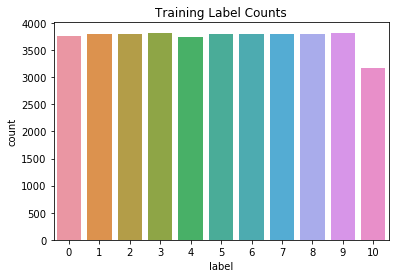

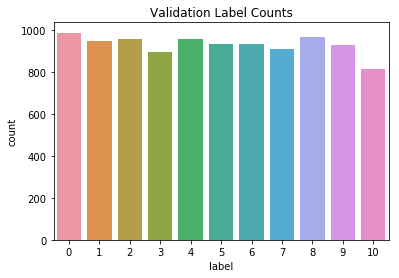

In [15]:
if DISPLAY:
    ax = sns.countplot(x=target_label, data=train_data)
    ax.set_title("Training Label Counts")
    ax.get_figure().savefig(paths["Logs"] + "training_target_counts.jpg")
    plt.show()
if DISPLAY:
    ax = sns.countplot(x=target_label, data=validation_data)
    ax.set_title("Validation Label Counts")
    ax.get_figure().savefig(paths["Logs"] + "validation_target_counts.jpg")
    plt.show()

In [16]:
# Separate Labels
train_labels = train_data.pop(target_label)
validation_labels = validation_data.pop(target_label)
train_data = train_data["Path"]
validation_data = validation_data["Path"]
test_data = test_data["Path"]

In [17]:
# Sanity check on data
print_and_log_header("TRAINING")
print_and_log(train_data.shape)
print_and_log(type(train_data))
print_and_log(train_labels.shape)
print_and_log(type(train_labels))
print_and_log_header("VALIDATION")
print_and_log(validation_data.shape)
print_and_log(type(validation_data))
print_and_log(validation_labels.shape)
print_and_log(type(validation_labels))
print_and_log_header("TESTING")
print_and_log(test_data.shape)
print_and_log(type(test_data))
print_and_log(test_labels.shape)
print_and_log(type(test_labels))
print_and_log(set(test_labels))

##########################################
                 TRAINING                 
##########################################
(41114,)
<class 'pandas.core.series.Series'>
(41114,)
<class 'pandas.core.series.Series'>
##########################################
                VALIDATION                
##########################################
(10242,)
<class 'pandas.core.series.Series'>
(10242,)
<class 'pandas.core.series.Series'>
##########################################
                 TESTING                  
##########################################
(158538,)
<class 'pandas.core.series.Series'>
(158538,)
<class 'pandas.core.series.Series'>
{0}


In [18]:
# Grab subset of the data for testing purposes
if TEST:
    train_data = train_data[:TEST_SIZE]
    train_labels = train_labels[:TEST_SIZE]
    validation_data = validation_data[:TEST_SIZE]
    validation_labels = validation_labels[:TEST_SIZE]
    test_data = test_data[:TEST_SIZE]
    test_labels = test_labels[:TEST_SIZE]
    ids = ids[:TEST_SIZE]

In [19]:
# Vectors of filenames.
train_filenames = tf.constant(train_data)
validation_filenames = tf.constant(validation_data)
test_filenames = tf.constant(test_data)

# `labels[i]` is the label for the image in `filenames[i]
# Vectors of labels
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)
test_labels = tf.constant(test_labels)

# Make datasets from filenames and labels
train_data = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
validation_data = tf.data.Dataset.from_tensor_slices((validation_filenames, validation_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))
print_and_log_header("Parsing Training Data")
train_data = timer(lambda: train_data.map(_parse_function))
print_and_log_header("Parsing Validation Data")
validation_data = timer(lambda: validation_data.map(_parse_function))
print_and_log_header("Parsing Testing Data")
test_data = timer(lambda: test_data.map(_parse_function))
print_and_log("\nDone!")

##########################################
          Parsing Training Data           
##########################################
Start: 2018-08-01 02:28:47.884741
End: 2018-08-01 02:28:48.046843
Finished in 00:00:00:00.162
##########################################
         Parsing Validation Data          
##########################################
Start: 2018-08-01 02:28:48.049643
End: 2018-08-01 02:28:48.184244
Finished in 00:00:00:00.134
##########################################
           Parsing Testing Data           
##########################################
Start: 2018-08-01 02:28:48.186230
End: 2018-08-01 02:28:48.308463
Finished in 00:00:00:00.122

Done!


In [20]:
print_and_log_header("TRAINING")
print_and_log(train_data)
print_and_log(type(train_data))
print_and_log_header("VALIDATION")
print_and_log(validation_data)
print_and_log(type(validation_data))
print_and_log_header("TESTING")
print_and_log(test_data)
print_and_log(type(test_data))

##########################################
                 TRAINING                 
##########################################
<MapDataset shapes: ((1, 28, 28, 1), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
##########################################
                VALIDATION                
##########################################
<MapDataset shapes: ((1, 28, 28, 1), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
##########################################
                 TESTING                  
##########################################
<MapDataset shapes: ((1, 28, 28, 1), ()), types: (tf.float32, tf.int32)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [21]:
# Create the Estimator
if TPU:
    classifier = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        model_dir=paths["Model"],
        config=tf.contrib.tpu.RunConfig(),
        use_tpu=TPU)
else:
    classifier = tf.estimator.Estimator(model_fn=model_fn, model_dir=paths["Model"])

In [22]:
# Create the input functions.
training_eval_input_fn = create_predict_input_fn(train_data, DEFAULT_BS)
validation_eval_input_fn = create_predict_input_fn(validation_data, DEFAULT_BS)
train_input_fn = create_training_input_fn(train_data, BATCH_SIZE)

In [23]:
# Train
classifier, accuracy, t_lls, v_lls, t_accs, v_accs = timer(train)

Start: 2018-08-01 02:28:48.399592
Training model...
Metrics:
	PERIOD	RATE	TYPE	TRAIN.	VALID.	TIME
	0	0.03750	LgLs	1.52	1.53	2018-08-01 02:39:33.685904
			Acc.	49.21%	48.88%

	1	0.03375	LgLs	1.10	1.11	2018-08-01 02:50:19.042204
			Acc.	63.86%	63.23%

	2	0.03037	LgLs	0.94	0.96	2018-08-01 03:00:31.012447
			Acc.	69.44%	68.53%

	3	0.02734	LgLs	0.87	0.90	2018-08-01 03:10:04.677041
			Acc.	71.32%	70.02%

	4	0.02460	LgLs	0.81	0.86	2018-08-01 03:20:45.252889
			Acc.	73.40%	71.64%

	5	0.02214	LgLs	0.76	0.81	2018-08-01 03:31:32.567592
			Acc.	74.84%	72.72%

	6	0.01993	LgLs	0.72	0.80	2018-08-01 03:42:20.968466
			Acc.	76.47%	73.68%

	7	0.01794	LgLs	0.71	0.79	2018-08-01 03:53:11.838675
			Acc.	76.64%	73.89%

	8	0.01614	LgLs	0.66	0.76	2018-08-01 04:03:53.254675
			Acc.	78.60%	74.87%

	9	0.01453	LgLs	0.64	0.75	2018-08-01 04:14:50.267331
			Acc.	79.19%	75.14%

	10	0.01308	LgLs	0.61	0.74	2018-08-01 04:25:47.963559
			Acc.	80.13%	75.57%

	11	0.01177	LgLs	0.60	0.74	2018-08-01 04:36:15.689255
			Acc.	80.

Final accuracy (on validation data): 76.6550%


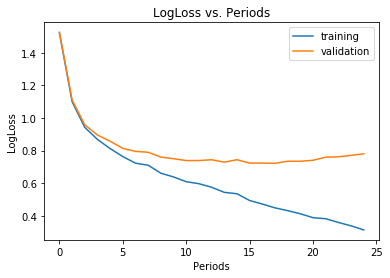

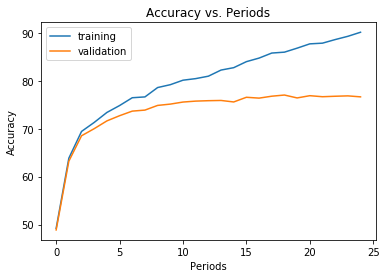

In [24]:
print_and_log("Final accuracy (on validation data): {:.4f}%".format(accuracy))

# Output a graph of loss metrics over periods.
if DISPLAY:
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(t_lls, label="training")
    plt.plot(v_lls, label="validation")
    plt.legend()
    plt.show()
    plt.savefig(paths["Logs"] + "loss.jpg")

# Output a graph of accuracy over periods.
if DISPLAY:
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Accuracy vs. Periods")
    plt.plot(t_accs, label="training")
    plt.plot(v_accs, label="validation")
    plt.legend()
    plt.show()
    plt.savefig(paths["Logs"] + "accuracy.jpg")

In [25]:
# Make Predictions
test_input_fn = create_predict_input_fn(test_data, DEFAULT_BS)
f = lambda: np.array([item for item in classifier.predict(input_fn=test_input_fn)])
predictions = timer(f)
classes = [x["classes"] for x in predictions]
prob = [x["probabilities"] for x in predictions]
df = pd.DataFrame({"classes":classes, "probabilities":prob})
df["probabilities"] = df["probabilities"].apply(lambda x: max(x))
predictions = {}
for i in range(10, 75, 5):
    threshold = i * 0.1 / num_labels
    df_copy = pd.DataFrame(df)
    df_copy.loc[df_copy['probabilities'] < threshold, 'classes'] = labels["unknown"]
    pred = df_copy["classes"]
    pred = [reverse_lookup[x] for x in pred]
    predictions[threshold] = pred

Start: 2018-08-01 06:57:04.908662
End: 2018-08-01 07:04:02.140352
Finished in 00:00:06:57.231


In [26]:
# Make the output Dataframes
outputs = {}
for key in predictions:
    outputs[key] = pd.DataFrame({id_label:ids, target_label:predictions[key]})

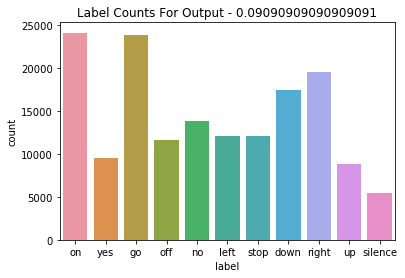

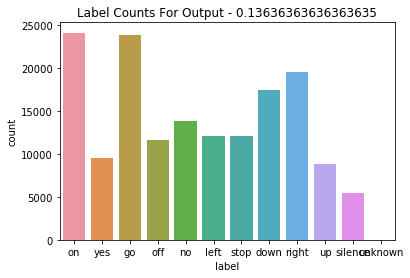

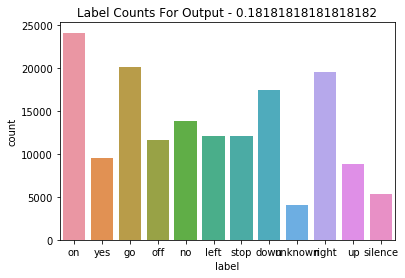

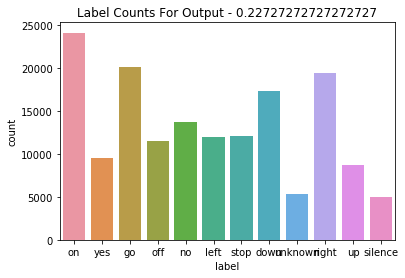

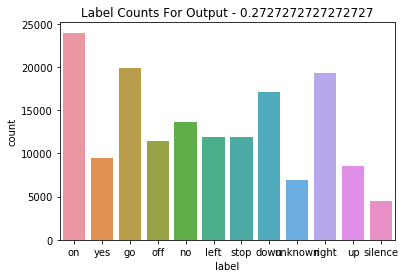

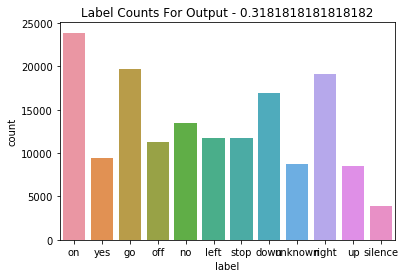

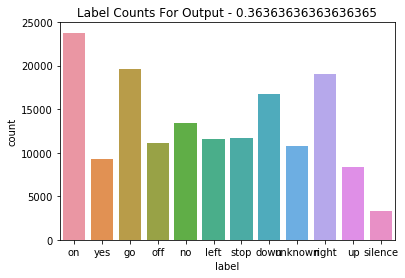

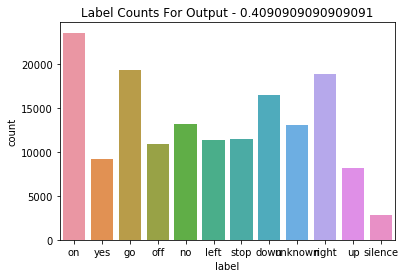

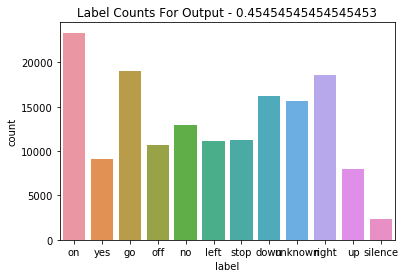

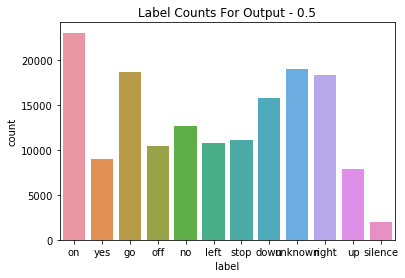

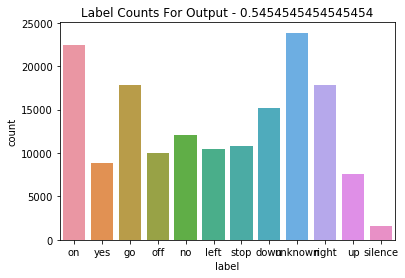

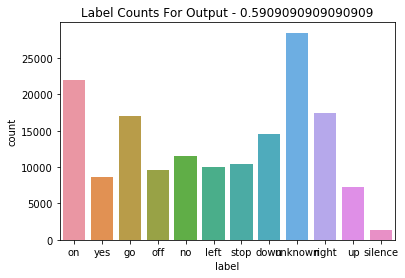

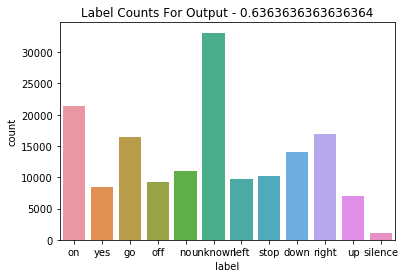

In [27]:
if DISPLAY:
    for key in sorted(outputs.keys()):
        ax = sns.countplot(x=target_label, data=outputs[key])
        ax.set_title("Label Counts For Output - {}".format(key))
        ax.get_figure().savefig(paths["Logs"] + "output_counts_{}.jpg".format(key))
        plt.show()

In [28]:
for key in sorted(outputs.keys()):
    output = outputs[key]
    name = OUTSTR.format(accuracy, TYPE, UNK_DROP_RATE, key, DROPOUT, LEARNING_RATE, LEARNING_STEPS, BATCH_SIZE,"_" + NOTES if NOTES else "")
    print_and_log("Filename: '{}'".format(name))
    if not TEST:
        output.to_csv(name, index=False)
        print_and_log("\tSaved!")

Filename: 'A76.6550_TypeCNN_UDR1.0_THRESH0.091_DROP0.4_LR0.0375_S20000_B64_MFCC_28x28_Combined_3.csv'
	Saved!
Filename: 'A76.6550_TypeCNN_UDR1.0_THRESH0.136_DROP0.4_LR0.0375_S20000_B64_MFCC_28x28_Combined_3.csv'
	Saved!
Filename: 'A76.6550_TypeCNN_UDR1.0_THRESH0.182_DROP0.4_LR0.0375_S20000_B64_MFCC_28x28_Combined_3.csv'
	Saved!
Filename: 'A76.6550_TypeCNN_UDR1.0_THRESH0.227_DROP0.4_LR0.0375_S20000_B64_MFCC_28x28_Combined_3.csv'
	Saved!
Filename: 'A76.6550_TypeCNN_UDR1.0_THRESH0.273_DROP0.4_LR0.0375_S20000_B64_MFCC_28x28_Combined_3.csv'
	Saved!
Filename: 'A76.6550_TypeCNN_UDR1.0_THRESH0.318_DROP0.4_LR0.0375_S20000_B64_MFCC_28x28_Combined_3.csv'
	Saved!
Filename: 'A76.6550_TypeCNN_UDR1.0_THRESH0.364_DROP0.4_LR0.0375_S20000_B64_MFCC_28x28_Combined_3.csv'
	Saved!
Filename: 'A76.6550_TypeCNN_UDR1.0_THRESH0.409_DROP0.4_LR0.0375_S20000_B64_MFCC_28x28_Combined_3.csv'
	Saved!
Filename: 'A76.6550_TypeCNN_UDR1.0_THRESH0.455_DROP0.4_LR0.0375_S20000_B64_MFCC_28x28_Combined_3.csv'
	Saved!
Filename: 